### Imports

In [58]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import statistics
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


from ucimlrepo import fetch_ucirepo 



### Distância de Minkowski

In [15]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


In [16]:
def calculateDistances(pontos, n):
    distances = [[] for _ in range(len(pontos))]
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            distances[i].append(calculateDist(p1, p2, n))
    return distances

### Função para vizualização

Para pontos em duas dimensões

In [17]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center,p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


Para pontos em três dimensões

In [18]:
def plotClusters3D(clusters, n):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('tab20b', len(clusters))
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=colors(i), label=f'Cluster {i + 1}')
        
        # Centro do cluster
        center = np.mean(cluster_points, axis=0)
        ax.scatter(center[0], center[1], center[2], color='black', marker='x')
        
        # Raio
        max_dist = max([calculateDist(center, p, n) for p in cluster])
        
        #Nesse caso temos uma esfera e não circulo
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = max_dist * np.cos(u) * np.sin(v) + center[0]
        y = max_dist * np.sin(u) * np.sin(v) + center[1]
        z = max_dist * np.cos(v) + center[2]
        
        ax.plot_surface(x, y, z, color=colors(i), alpha=0.3, edgecolor='none')
        ax.text(center[0], center[1], center[2] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Clusters')
    ax.legend()
    plt.show()

Para várias dimensões a vizualização em gráficos fica inviável

In [19]:
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

Função auxiliar 

In [20]:
def get_labels(clusters, pontos):
    labels = [-1] * len(pontos)  # Initialize labels with -1 for safety
    point_to_label = {}

    # Create a mapping from each point to its cluster label
    for cluster_index, cluster in enumerate(clusters):
        for point in cluster:
            point_to_label[tuple(point)] = cluster_index

    # Assign labels to the original points based on the mapping
    for i, point in enumerate(pontos):
        labels[i] = point_to_label[tuple(point)]
        
    return labels

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [21]:
#Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while len(pts) > 0:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


Agora podemos ir para a implementação do algoritmo em si:

In [22]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia,distMatrix,true_labels):
    limite_superior = max(max(row) for row in distMatrix)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    success = False
    
    while not(success) or ((limite_superior-limite_inferior) >= (porcentagem_largura*largura_total)):
        success, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if success:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
    
            
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)
    
    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari

### Segunda versão do algoritmo 2-aproximado

Nessa os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [23]:
#Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n, distMatrix):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = distMatrix[pontos.index(p)][pontos.index(c)]
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

#Determina os centros dos clusters
def getCenters(pontos,k_clusters,n,distMatrix):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n, distMatrix)
        centers.append(s)
    return centers

#Determina o centro mais próximo do ponto p
def find_closest_center(pontos, centers, p, n, distMatrix):
    minDist = np.inf
    for c in centers:
        dist = distMatrix[pontos.index(p)][pontos.index(c)]
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

#Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n, distMatrix, true_labels):
    centers = getCenters(pontos, k_clusters, n, distMatrix)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(pontos, centers, p, n, distMatrix)
        clusters[centers.index(closest_center)].append(p)
    # calcula o raio de cada cluster
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)

    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari


### Kmeans

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def performKmeans(pontos, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pontos)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(pontos[i])

    for i in range(n_clusters):
        clusters[i] = np.array(clusters[i])
    
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)

    radii = []
    centroids = kmeans.cluster_centers_
    for i in range(kmeans.n_clusters):
        # Get points in the cluster
        cluster_points = clusters[i]
        
        # Calculate distances from the centroid
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        
        # Get the maximum distance as the radius
        radius = np.max(distances)
        radii.append(radius)

    return clusters, radii, sil_score, ari


## Dados

### Carregamento dos dados reais

In [65]:
print(car_evaluation.variables) 

       name     role         type demographic  \
0    buying  Feature  Categorical        None   
1     maint  Feature  Categorical        None   
2     doors  Feature  Categorical        None   
3   persons  Feature  Categorical        None   
4  lug_boot  Feature  Categorical        None   
5    safety  Feature  Categorical        None   
6     class   Target  Categorical        None   

                                         description units missing_values  
0                                       buying price  None             no  
1                           price of the maintenance  None             no  
2                                    number of doors  None             no  
3              capacity in terms of persons to carry  None             no  
4                           the size of luggage boot  None             no  
5                        estimated safety of the car  None             no  
6  evaulation level (unacceptable, acceptable, go...  None             no  

In [64]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Supondo que `X` e `y` sejam DataFrames ou Series carregados do car_evaluation
X = car_evaluation.data.features
y = car_evaluation.data.targets

# Transformando as labels em valores numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Transformando as colunas de `X` em valores numéricos
# Primeiro, precisamos converter X para um formato adequado, se ainda não estiver
X_encoded = pd.get_dummies(X)

# Se você preferir usar o OneHotEncoder
one_hot_encoder = OneHotEncoder()
X_encoded = one_hot_encoder.fit_transform(X)

# Verificando os resultados
print("Features (X) com valores numéricos:")
print(X_encoded)
print("\nLabels (y) com valores numéricos:")
print(y_encoded)

Features (X) com valores numéricos:
     buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    low
1     vhigh  vhigh      2       2    small    med
2     vhigh  vhigh      2       2    small   high
3     vhigh  vhigh      2       2      med    low
4     vhigh  vhigh      2       2      med    med
...     ...    ...    ...     ...      ...    ...
1723    low    low  5more    more      med    med
1724    low    low  5more    more      med   high
1725    low    low  5more    more      big    low
1726    low    low  5more    more      big    med
1727    low    low  5more    more      big   high

[1728 rows x 6 columns]

Labels (y) com valores numéricos:
[2 2 2 ... 2 1 3]


/home/diogo/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Geração de datasets sintéticos

##### Normal multivariada

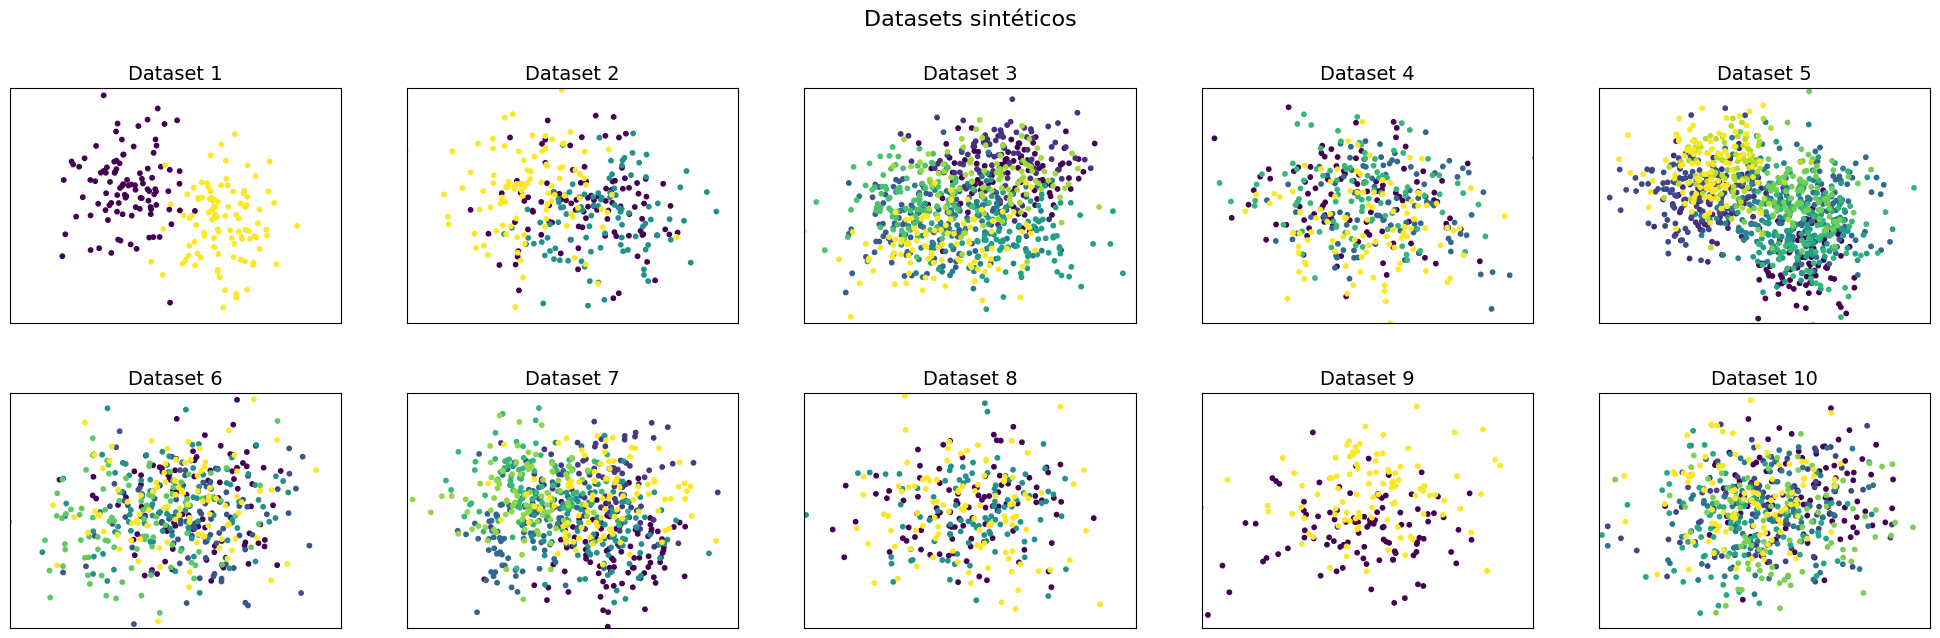

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def generate_random_coordinates(x):
    coordinates = np.random.rand(x, 2)
    return coordinates

def generateSyntheticDataWithLabels(centers, std_dev, num_points_per_center):
    pontos = []
    labels = []
    
    for idx, center in enumerate(centers):
        cov_matrix = [[std_dev**2, 0], [0, std_dev**2]]
        points = np.random.multivariate_normal(mean=center, cov=cov_matrix, size=num_points_per_center)
        pontos.append(points)
        labels.extend([idx] * num_points_per_center)  # Assign label idx to each point
    
    return np.vstack(pontos), np.array(labels)

def apply_standard_scaling(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Parameters for synthetic data generation
n_clusters = [2, 3, 8, 4, 10, 5, 7, 3, 2, 6]  # Número de clusters variado
std_devs = [0.1, 0.5, 0.3, 1.0, 0.2, 0.7, 0.4, 1.5, 0.6, 0.9]  # Desvios padrão variáveis

base_num_points = 100
num_points_per_center = [int(base_num_points) for std_dev in std_devs]

data = []
labels_list = []
for i in range(10):
    centers = generate_random_coordinates(n_clusters[i])
    dataset, labels = generateSyntheticDataWithLabels(centers, std_devs[i], num_points_per_center[i])
    scaled_dataset = apply_standard_scaling(dataset)
    data.append(scaled_dataset)
    labels_list.append(labels)

# Plotting
n_rows = 2
n_cols = 5
plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.2, hspace=0.3)

for i in range(10):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f"Dataset {i+1}", size=14)
    plt.scatter(data[i][:, 0], data[i][:, 1], c=labels_list[i], s=10, cmap='viridis')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xticks(())
    plt.yticks(())

plt.suptitle("Datasets sintéticos", size=16, y=1.05)
plt.show()

##### Exemplos scikit learn

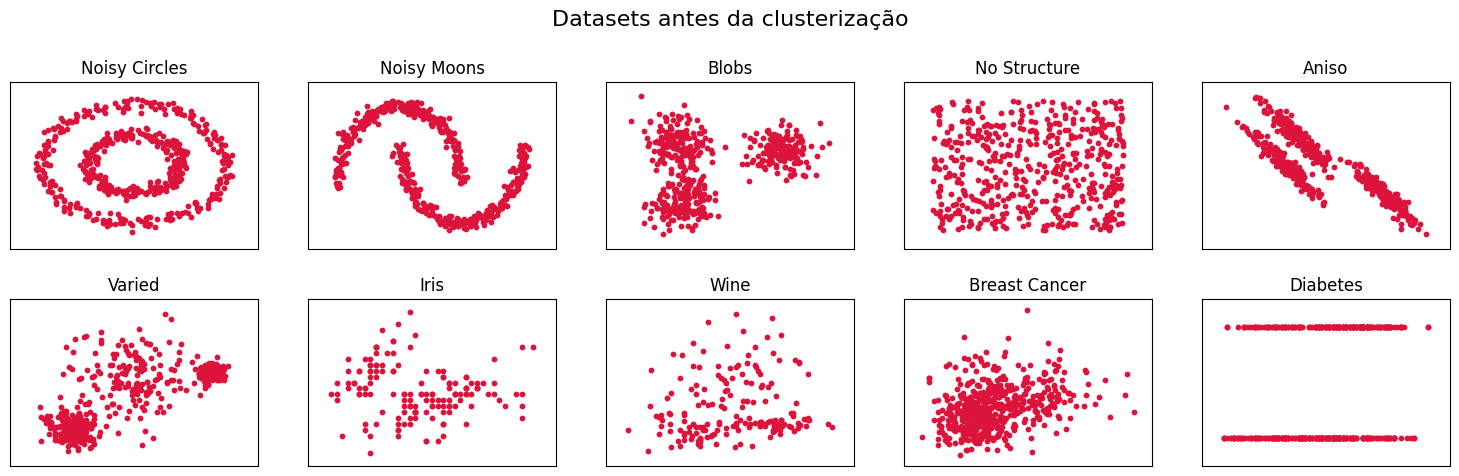

In [27]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load original datasets
noisy_circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=30) #2 labels
noisy_moons = datasets.make_moons(n_samples=500, noise=0.05, random_state=30) #2 labels
blobs = datasets.make_blobs(n_samples=500, random_state=30) #3 labels
rng = np.random.RandomState(30)
no_structure = rng.rand(500, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)#3 labels

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=170)#3 labels

# Load new datasets
iris = datasets.load_iris(return_X_y=True)#3 labels
wine = datasets.load_wine(return_X_y=True)#3 labels
breast_cancer = datasets.load_breast_cancer(return_X_y=True) #2 labels
diabetes = datasets.load_diabetes(return_X_y=True)

# List of datasets and titles
datasets_list = [
    noisy_circles, noisy_moons, blobs, no_structure,
    aniso, varied, iris, wine, breast_cancer, diabetes
]
dataset_titles = [
    'Noisy Circles', 'Noisy Moons', 'Blobs', 'No Structure',
    'Aniso', 'Varied', 'Iris', 'Wine', 'Breast Cancer', 'Diabetes'
]

# Plot settings
n_cols = 5
n_rows = 2
fig_size = (4 * n_cols * 0.8, 3 * n_rows * 0.8)
plt.figure(figsize=fig_size)
plt.subplots_adjust(
    left=0.05, right=0.95, bottom=0.05, top=0.85, wspace=0.2, hspace=0.3
)

plt.suptitle('Datasets antes da clusterização', size=16, y=1.0)

for i, (dataset, title) in enumerate(zip(datasets_list, dataset_titles)):
    if len(dataset) == 2:
        X, _ = dataset  # For datasets that return X and y
    else:
        X, _ = dataset
    X = StandardScaler().fit_transform(X)
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(title, size=12)
    
    plt.scatter(X[:, 0], X[:, 1], s=10, color="crimson")
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())

plt.show()


## Testes

In [55]:
def executeAll(data, k_clusters, n_distance, labels, nome_test, n_experimentos=30):
    pontos = data.tolist()
    distMatrix = calculateDistances(pontos, n_distance)

    # Armazenar resultados do Algoritmo 1
    resultados = []

    percentages = np.linspace(0.08, 0.25, num=6)
    
    for percentage in percentages:
        percentage = np.around(percentage, decimals=3)
        dur_alg1 = []
        max_rai_alg1 = []
        mean_rai_alg1 = []
        sil_alg1 = []
        ra_alg1 = []

        for _ in range(n_experimentos):
            # Algoritmo 1
            start_time = datetime.now()
            clusters_1, raios_1, sil_1, r_1 = k_clustering(pontos, percentage, k_clusters, n_distance, distMatrix, labels)
            end_time = datetime.now()
            duration = (end_time - start_time).total_seconds() * 1000

            dur_alg1.append(duration)
            raios_1 = [sublista[0] for sublista in raios_1]
            max_rai_alg1.append(max(raios_1))
            mean_rai_alg1.append(statistics.mean(raios_1))
            sil_alg1.append(sil_1)
            ra_alg1.append(r_1)

        # Calculando médias para o Algoritmo 1
        mean_dur_alg1 = round(np.mean(dur_alg1), 4)
        mean_max_rai_alg1 = round(np.mean(max_rai_alg1), 4)
        mean_mean_rai_alg1 = round(np.mean(mean_rai_alg1), 4)
        mean_sil_alg1 = round(np.mean(sil_alg1), 4)
        mean_ra_alg1 = round(np.mean(ra_alg1), 4)

        # Adicionando resultados à lista
        resultados.append({
            'Modelo': f"Algoritmo 1 com intervalo {percentage}",
            'Duração Algoritmo (ms)': mean_dur_alg1,
            'Maior Raio': mean_max_rai_alg1,
            'Média Raios': mean_mean_rai_alg1,
            'Silhueta': mean_sil_alg1,
            'Índice de Rand Ajustado': mean_ra_alg1,
        })

    # Inicializar listas para o Algoritmo 2
    dur_alg2 = []
    max_rai_alg2 = []
    mean_rai_alg2 = []
    sil_alg2 = []
    ra_alg2 = []

    # Executando Algoritmo 2 30 vezes
    for _ in range(n_experimentos):
        start_time = datetime.now()
        clusters_2, raios_2, sil_2, r_2 = makeClusters(pontos, k_clusters, n_distance, distMatrix, labels)
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() * 1000

        dur_alg2.append(duration)
        raios_2 = [sublista[0] for sublista in raios_2]
        max_rai_alg2.append(max(raios_2))
        mean_rai_alg2.append(statistics.mean(raios_2))
        sil_alg2.append(sil_2)
        ra_alg2.append(r_2)

    # Calculando médias para o Algoritmo 2
    mean_dur_alg2 = round(np.mean(dur_alg2), 4)
    mean_max_rai_alg2 = round(np.mean(max_rai_alg2), 4)
    mean_mean_rai_alg2 = round(np.mean(mean_rai_alg2), 4)
    mean_sil_alg2 = round(np.mean(sil_alg2), 4)
    mean_ra_alg2 = round(np.mean(ra_alg2), 4)

    resultados.append({
        'Modelo': "Algoritmo 2",
        'Duração Algoritmo (ms)': mean_dur_alg2,
        'Maior Raio': mean_max_rai_alg2,
        'Média Raios': mean_mean_rai_alg2,
        'Silhueta': mean_sil_alg2,
        'Índice de Rand Ajustado': mean_ra_alg2,
    })
    
    # Executando Kmeans (apenas uma vez)
    start_time = datetime.now()
    clusters_kmeans, raios_kmeans, sil_kmeans, r_kmeans = performKmeans(pontos, labels, k_clusters)
    end_time = datetime.now()
    duration_kmeans = (end_time - start_time).total_seconds() * 1000

    max_rai_kmeans = round(max(raios_kmeans), 4)
    mean_rai_kmeans = round(statistics.mean(raios_kmeans), 4)

    # Adicionando resultados do Algoritmo 2 e Kmeans à lista
    resultados.append({
        'Modelo': "Kmeans",
        'Duração Algoritmo (ms)': round(duration_kmeans, 4),
        'Maior Raio': max_rai_kmeans,
        'Média Raios': mean_rai_kmeans,
        'Silhueta': round(sil_kmeans, 4),
        'Índice de Rand Ajustado': round(r_kmeans, 4),
    })

    # Preparando a tabela de resultados
    report_table_df = pd.DataFrame(resultados)

    fig, ax = plt.subplots(figsize=(35, 8))
    ax.axis('tight')
    ax.axis('off')
    fig.text(0.90, 0.01, f"{nome_test}", fontsize=8, ha='right', va='bottom', alpha=0.8)

    table = ax.table(cellText=report_table_df.values, colLabels=report_table_df.columns, cellLoc='center', loc='center')
    table.scale(1, 4)

    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_text_props(weight='bold')

    plt.show()

    return report_table_df


### Teste de datasets sintéticos

##### Normal multivariada

##### Exemplos do scikit learn

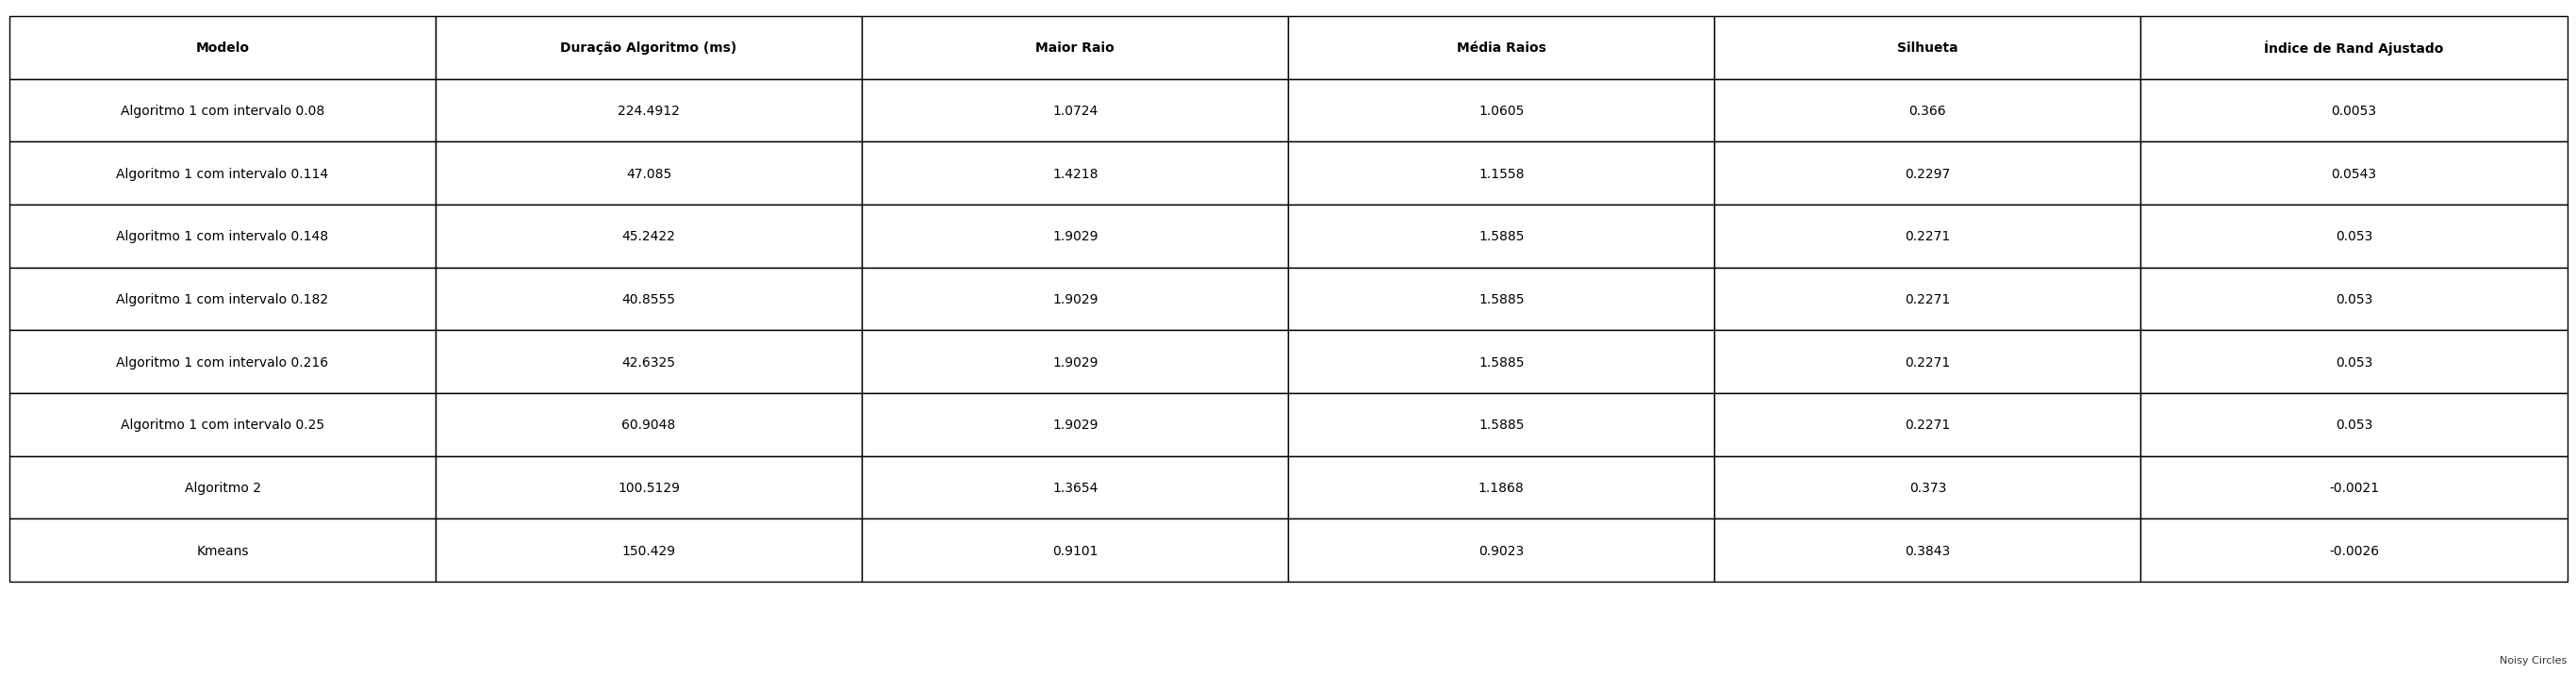

,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.08,224.4912,1.0724,1.0605,0.3660,0.0053
1,Algoritmo 1 com intervalo 0.114,47.0850,1.4218,1.1558,0.2297,0.0543
2,Algoritmo 1 com intervalo 0.148,45.2422,1.9029,1.5885,0.2271,0.0530
3,Algoritmo 1 com intervalo 0.182,40.8555,1.9029,1.5885,0.2271,0.0530
4,Algoritmo 1 com intervalo 0.216,42.6325,1.9029,1.5885,0.2271,0.0530
5,Algoritmo 1 com intervalo 0.25,60.9048,1.9029,1.5885,0.2271,0.0530
6,Algoritmo 2,100.5129,1.3654,1.1868,0.3730,-0.0021
7,Kmeans,150.4290,0.9101,0.9023,0.3843,-0.0026


In [56]:
executeAll(noisy_circles[0], 3,2, noisy_circles[1],"Noisy Circles") 

ACABAR DE COLOCAR OS DADOS